## Eval all losses

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%autoreload

In [3]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import segmentation_models_pytorch as smp
from natsort import natsorted
from uloss_wmh.fitting.fitter import StandardLitModelWrapper
from uloss_wmh.fitting.optimizer_constructor import OptimizerConfigurator, standard_configurations
from tqdm import tqdm

In [4]:
from uloss_wmh.evaluate.eval_metrics.weighted_average_challenge_metrics import weighted_challenge_metrics

In [5]:
from uloss_wmh.evaluate.eval_metrics.challenge_metrics import do_challenge_metrics, per_model_chal_stats, challenge_results_combined_lists

In [6]:
# loss functions
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss, DiceCELoss, DiceFocalLoss
from uloss_wmh.loss_functions.brier import Brier, BrierPlusDice
from uloss_wmh.loss_functions.odyssey_dice import SoftDiceLoss, DC_and_topk_loss
from uloss_wmh.loss_functions.odyssey_ND_Crossentropy import TopKLoss, CrossentropyND
from uloss_wmh.loss_functions.dice_plusplus import DicePlusPlusLoss

### loading the train, val and test datasets in 3D this time.

In [7]:
from ulw_data.torch_dataset.challenge_dataset_3D import load_3D_wmh_chal
from ulw_data.torch_dataset.challenge_data_pipeline import train_data_pipeline

In [10]:
collated_folder = "/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset_norm05/preprocessed/collated/"
train_ds, val_ds = train_data_pipeline(ds_path=collated_folder, val_proportion=0.15, seed=5, transforms=None, dims=3)

In [11]:
test_dss = load_3D_wmh_chal(ds_path=collated_folder, train=False, combine=False, remove_mask_channel=False)

In [12]:
len(test_dss)

5

In [13]:
test_dss[4][0]['uid']

'test_Utrecht_1'

In [14]:
# computing the voxel histogram for each image in the test dataset.
example = test_dss[0][0]['image'][0]

In [15]:
flat = example.view(-1)
flat = flat[flat != 0]

In [16]:
# get volumes:
from uloss_wmh.evaluate.eval_metrics.WMH_volume import GT_volumes

ys3d = []
for ds in test_dss:
    for data in ds:
        label = data['label']
        ys3d.append(label)
    # break # UNCOMMENT DEBUG
    
volumes = GT_volumes(ys3d, 0.0003)
# volumes = volumes[0:10] ## UNCOMMENT DEBUG

Text(0.5, 0, 'WMH Volume per individual - $mm^3$')

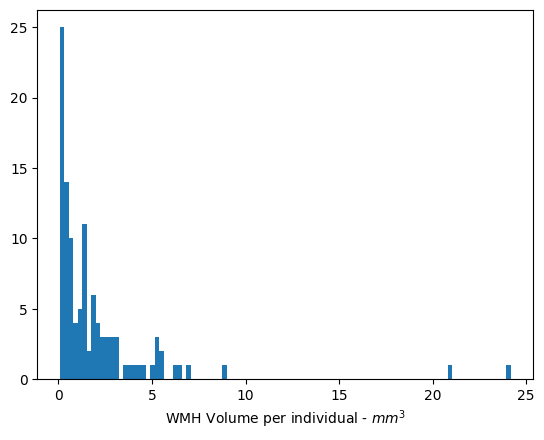

In [17]:
plt.hist(volumes, bins=100)
plt.xlabel(r"WMH Volume per individual - $mm^3$")

In [18]:
masks = []
for ds in test_dss:
    for data in ds:
        mask = data['image'][2]
        masks.append(mask)
    # break # UNCOMMENT DEBUG

In [19]:
test_dss[0][0]['label'].dtype

torch.int64

In [20]:
labels_dss = [[] for _ in range(len(test_dss))]
labels = []

for i, ds in enumerate(test_dss):
    for data in ds:
        label = data['label'].squeeze()
        labels.append(label)
        labels_dss[i].append(label==1)
    # break # UNCOMMMENT DEBUG

In [21]:
def load_model_preds(model, t=1):
    preds_dss = []
    with torch.no_grad():
        model.eval()
        for ds in test_dss:
            preds_domain = []
            for data in tqdm(ds):
                inp = data['image'].cuda().moveaxis(-1, 0)
                inp = inp[:,0:2] # remove the mask channel
                out = model(inp)
                
                if out.shape[1] > 1:
                    out = torch.softmax(out/t, dim=1)
                else:
                    out = torch.sigmoid(out/t)
                
                preds_domain.append(out.moveaxis(0, -1).squeeze().cpu())
            preds_dss.append(preds_domain)
            # break # UNCOMMENT DEBUG
    
    # get combined list of all domains together
    preds = []
    for p in preds_dss:
        preds.extend(p)
        
    return preds, preds_dss

In [22]:
def combined_challenge_metrics(preds_domain, labels_domain, model, folder_name):
    results_domain = []
    for i in range(len(preds_domain)):
        results_domain.append(per_model_chal_stats([(p.argmax(dim=0)==1) for p in preds_domain[i]], labels_domain[i], do_argmax=False))
        
    results_combined_df = challenge_results_combined_lists(results_domain, folder_name)
    
    return results_combined_df, results_domain

### compute the metrics for each metric

In [23]:
model_base = smp.Unet(
        encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=2,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=3,                      # model output channels (number of classes in your dataset)
    )

In [24]:
models_root = "/media/benp/NVMEspare/project_data/loss_func_proj/models/new_models"
model_dirs = os.listdir(models_root)

In [25]:
model_dirs

['dice_plusplus_gamma2_2',
 'spherical_topk10_1',
 'spherical_topk10_2',
 'spherical_topk1_1',
 'spherical_topk1_2',
 'spherical_topk1_3',
 'xent_e_1',
 'xent_e_2',
 'xent_e_3',
 'xent_topk10_1',
 'xent_topk10_2',
 'xent_topk10_3',
 'xent_topk1_1',
 'xent_topk1_2',
 'xent_topk1_3',
 'xent_unscaled_1',
 'xent_unscaled_2',
 'xent_unscaled_3',
 'dice_plusplus_gamma2_3',
 'dice_plusplus_gamma3_1',
 'dice_plusplus_gamma3_2',
 'dice_plusplus_gamma3_3',
 'dice_plusplus_gamma4_1',
 'dice_plusplus_gamma4_2',
 'dice_plusplus_gamma4_3',
 'dice_standard_1',
 'dice_standard_2',
 'dice_standard_3',
 'dice_temp_scaled_1',
 'dice_temp_scaled_2',
 'dice_temp_scaled_3',
 'spherical_alpha2_1',
 'spherical_alpha2_2',
 'spherical_alpha2_3',
 'brier_power2_1',
 'brier_power2_2',
 'brier_power2_3',
 'brier_topk10_1',
 'brier_topk10_2',
 'brier_topk10_3',
 'brier_topk1_1',
 'brier_topk1_2',
 'brier_topk1_3',
 'dice_4',
 'dice_partial_temp_scale_1',
 'dice_partial_temp_scale_2',
 'dice_partial_temp_scale_3']

In [26]:
custom_optim_config = OptimizerConfigurator(optim='Adam', lr=3e-4, weight_decay=0, scheduler='ReduceOnPlateau', patience=12, threshold=1e-4, factor=0.3, min_lr=1e-6, monitor='train_loss', verbose_lr=True)

In [27]:
natsorted(os.listdir(f"{models_root}/{model_dirs[0]}"))[1]

'epoch=108-step=7412.ckpt'

In [60]:
%autoreload

In [62]:
selected_folders = [
 'spherical_topk1_1',
 'spherical_topk1_2',
 'spherical_topk1_3',
 'xent_e_1',
 'xent_e_2',
 'xent_e_3',
 'xent_topk10_1',
 'xent_topk10_2',
 'xent_topk10_3',
 'dice_plusplus_gamma3_1',
 'dice_plusplus_gamma3_2',
 'dice_plusplus_gamma3_3',
 'dice_standard_1',
 'dice_standard_2',
 'dice_standard_3',
 'spherical_alpha2_1',
 'spherical_alpha2_2',
 'spherical_alpha2_3',
 'brier_power2_1',
 'brier_power2_2',
 'brier_power2_3',
 'brier_topk10_1',
 'brier_topk10_2',
 'brier_topk10_3',
 ]

In [64]:
for i in range(len(model_dirs)):
    
    folder_name = model_dirs[i]
    print(folder_name)
    
    if folder_name not in selected_folders:
        continue
    
    try:
        ckpt_path = f"{models_root}/{model_dirs[i]}/{natsorted(os.listdir(f'{models_root}/{model_dirs[i]}'))[1]}"
    except:
        print(f"failed for {folder_name}")
        continue
    
    if "partial_temp_scale" in folder_name:
        print("skipping partial temp scale")
        continue
        
    model = StandardLitModelWrapper.load_from_checkpoint(checkpoint_path=ckpt_path, model=model_base, loss=None, optimizer_configurator=custom_optim_config)
    
    # try:
    #     os.mkdir(f"new_model_results/{folder_name}")
    # except:
    #     print("assume folder exists")
    #     continue
        
    tau = 1
    if "dice_temp_scaled_3" == folder_name:
        tau = 14.5
    elif "dice_temp_scaled_2" == folder_name:
        tau = 19.5
    elif "dice_temp_scaled_1" == folder_name:
        tau = 19.5
    print("tau: ", tau)
        
    preds, preds_dss = load_model_preds(model, tau)
    combined_metrics, metrics_per_domain = combined_challenge_metrics(preds_dss, labels_dss, model, folder_name)
    
    chal_metrics = weighted_challenge_metrics(metrics_per_domain)
    print(chal_metrics)
    
    with open(f"new_model_results/{folder_name}/new_hd95.txt", "w") as f:
        f.write(f"hd95: {chal_metrics['hd95']}\n")

dice_plusplus_gamma2_2
spherical_topk10_1
spherical_topk10_2
spherical_topk1_1
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.05it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.40it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.47it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.40it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.39it/s]


{'dice': 0.7599999904632568, 'f1': 0.7099999785423279, 'avd': 19.850000381469727, 'hd95': 6.440000057220459, 'recall': 0.6800000071525574}
spherical_topk1_2
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.97it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.41it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.39it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.41it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.44it/s]


{'dice': 0.7599999904632568, 'f1': 0.7099999785423279, 'avd': 18.40999984741211, 'hd95': 6.590000152587891, 'recall': 0.699999988079071}
spherical_topk1_3
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.79it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.48it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.48it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.48it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.46it/s]


{'dice': 0.7699999809265137, 'f1': 0.7099999785423279, 'avd': 20.639999389648438, 'hd95': 6.090000152587891, 'recall': 0.7200000286102295}
xent_e_1
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.70it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.41it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.46it/s]


{'dice': 0.7599999904632568, 'f1': 0.7200000286102295, 'avd': 21.440000534057617, 'hd95': 6.420000076293945, 'recall': 0.7099999785423279}
xent_e_2
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.80it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.43it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.41it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.40it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]


{'dice': 0.7599999904632568, 'f1': 0.7300000190734863, 'avd': 19.600000381469727, 'hd95': 6.010000228881836, 'recall': 0.699999988079071}
xent_e_3
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.80it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.47it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.49it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.50it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.47it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.46it/s]


{'dice': 0.7599999904632568, 'f1': 0.7300000190734863, 'avd': 20.65999984741211, 'hd95': 6.139999866485596, 'recall': 0.7200000286102295}
xent_topk10_1
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.81it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.48it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.48it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.45it/s]


{'dice': 0.7599999904632568, 'f1': 0.7300000190734863, 'avd': 19.260000228881836, 'hd95': 5.960000038146973, 'recall': 0.7099999785423279}
xent_topk10_2
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.75it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.43it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.44it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.48it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]


{'dice': 0.7599999904632568, 'f1': 0.7200000286102295, 'avd': 20.540000915527344, 'hd95': 6.21999979019165, 'recall': 0.6899999976158142}
xent_topk10_3
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.79it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.47it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.43it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]


{'dice': 0.7599999904632568, 'f1': 0.7099999785423279, 'avd': 19.969999313354492, 'hd95': 5.989999771118164, 'recall': 0.7300000190734863}
xent_topk1_1
xent_topk1_2
xent_topk1_3
xent_unscaled_1
xent_unscaled_2
xent_unscaled_3
dice_plusplus_gamma2_3
dice_plusplus_gamma3_1
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.84it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.49it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.49it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.44it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.43it/s]


{'dice': 0.7400000095367432, 'f1': 0.6600000262260437, 'avd': 29.420000076293945, 'hd95': 6.5, 'recall': 0.6899999976158142}
dice_plusplus_gamma3_2
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.73it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.43it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.37it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.44it/s]


{'dice': 0.7400000095367432, 'f1': 0.6600000262260437, 'avd': 26.559999465942383, 'hd95': 6.619999885559082, 'recall': 0.699999988079071}
dice_plusplus_gamma3_3
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.79it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.48it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.48it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.47it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.46it/s]


{'dice': 0.7400000095367432, 'f1': 0.6800000071525574, 'avd': 26.1299991607666, 'hd95': 6.670000076293945, 'recall': 0.7099999785423279}
dice_plusplus_gamma4_1
dice_plusplus_gamma4_2
dice_plusplus_gamma4_3
dice_standard_1
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.74it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.43it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.44it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.43it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.41it/s]


{'dice': 0.7200000286102295, 'f1': 0.6399999856948853, 'avd': 36.54999923706055, 'hd95': 8.140000343322754, 'recall': 0.6000000238418579}
dice_standard_2
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.80it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.42it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.45it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.42it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.40it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]


{'dice': 0.699999988079071, 'f1': 0.6100000143051147, 'avd': 45.93000030517578, 'hd95': 8.90999984741211, 'recall': 0.6399999856948853}
dice_standard_3
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.79it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.44it/s]


{'dice': 0.7300000190734863, 'f1': 0.6299999952316284, 'avd': 25.219999313354492, 'hd95': 8.789999961853027, 'recall': 0.550000011920929}
dice_temp_scaled_1
dice_temp_scaled_2
dice_temp_scaled_3
spherical_alpha2_1
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.74it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.47it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.44it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.45it/s]


{'dice': 0.7599999904632568, 'f1': 0.6899999976158142, 'avd': 21.639999389648438, 'hd95': 6.619999885559082, 'recall': 0.6600000262260437}
spherical_alpha2_2
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.74it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.41it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.50it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.45it/s]


{'dice': 0.7599999904632568, 'f1': 0.699999988079071, 'avd': 19.770000457763672, 'hd95': 6.71999979019165, 'recall': 0.6600000262260437}
spherical_alpha2_3
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.67it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]


{'dice': 0.7599999904632568, 'f1': 0.7099999785423279, 'avd': 19.469999313354492, 'hd95': 6.25, 'recall': 0.699999988079071}
brier_power2_1
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.75it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.44it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.41it/s]


{'dice': 0.7599999904632568, 'f1': 0.699999988079071, 'avd': 21.209999084472656, 'hd95': 6.639999866485596, 'recall': 0.6499999761581421}
brier_power2_2
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.72it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.42it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.43it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.42it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.43it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.37it/s]


{'dice': 0.75, 'f1': 0.6700000166893005, 'avd': 20.450000762939453, 'hd95': 7.320000171661377, 'recall': 0.6299999952316284}
brier_power2_3
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.59it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:23<00:00,  1.30it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.32it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.36it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.45it/s]


{'dice': 0.7599999904632568, 'f1': 0.6800000071525574, 'avd': 20.479999542236328, 'hd95': 6.940000057220459, 'recall': 0.6299999952316284}
brier_topk10_1
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.81it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.47it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.35it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.34it/s]


{'dice': 0.7599999904632568, 'f1': 0.7099999785423279, 'avd': 20.84000015258789, 'hd95': 6.690000057220459, 'recall': 0.6800000071525574}
brier_topk10_2
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.36it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.43it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.42it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.39it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.40it/s]


{'dice': 0.7599999904632568, 'f1': 0.7200000286102295, 'avd': 20.34000015258789, 'hd95': 6.300000190734863, 'recall': 0.7200000286102295}
brier_topk10_3
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.77it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.43it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.41it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.44it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.43it/s]

{'dice': 0.7599999904632568, 'f1': 0.7099999785423279, 'avd': 21.639999389648438, 'hd95': 6.300000190734863, 'recall': 0.7200000286102295}
brier_topk1_1
brier_topk1_2
brier_topk1_3
dice_4
dice_partial_temp_scale_1
dice_partial_temp_scale_2
dice_partial_temp_scale_3


In [57]:
import SimpleITK as sitk
import numpy as np
import torch
from tqdm import tqdm
import scipy


def getHausdorff(testImage, resultImage):
    """Compute the Hausdorff distance."""

    testImage = sitk.GetImageFromArray(testImage)
    resultImage = sitk.GetImageFromArray(resultImage)
    testImage.SetSpacing(1.,1.,3.)
    resultImage.SetSpacing(1.,1.,3.)

    # Hausdorff distance is only defined when something is detected
    resultStatistics = sitk.StatisticsImageFilter()
    resultStatistics.Execute(resultImage)
    if resultStatistics.GetSum() == 0:
        return float('nan')

    # Edge detection is done by ORIGINAL - ERODED, keeping the outer boundaries of lesions. Erosion is performed in 2D
    eTestImage   = sitk.BinaryErode(testImage, (1,1,0) )
    eResultImage = sitk.BinaryErode(resultImage, (1,1,0) )

    hTestImage   = sitk.Subtract(testImage, eTestImage)
    hResultImage = sitk.Subtract(resultImage, eResultImage)

    hTestArray   = sitk.GetArrayFromImage(hTestImage)
    hResultArray = sitk.GetArrayFromImage(hResultImage)   

    # Convert voxel location to world coordinates. Use the coordinate system of the test image
    # np.nonzero   = elements of the boundary in numpy order (zyx)
    # np.flipud    = elements in xyz order
    # np.transpose = create tuples (x,y,z)
    # testImage.TransformIndexToPhysicalPoint converts (xyz) to world coordinates (in mm)
    testCoordinates   = [testImage.TransformIndexToPhysicalPoint(x.tolist()) for x in np.transpose( np.flipud( np.nonzero(hTestArray) ))]
    resultCoordinates = [testImage.TransformIndexToPhysicalPoint(x.tolist()) for x in np.transpose( np.flipud( np.nonzero(hResultArray) ))]


    # Use a kd-tree for fast spatial search
    def getDistancesFromAtoB(a, b):    
        kdTree = scipy.spatial.KDTree(a, leafsize=100)
        return kdTree.query(b, k=1, eps=0, p=2)[0]

    # Compute distances from test to result; and result to test
    dTestToResult = getDistancesFromAtoB(testCoordinates, resultCoordinates)
    dResultToTest = getDistancesFromAtoB(resultCoordinates, testCoordinates)    

    return max(np.percentile(dTestToResult, 95), np.percentile(dResultToTest, 95))

In [58]:
preds[0].shape, labels[0].shape

(torch.Size([3, 192, 224, 64]), torch.Size([192, 224, 64]))

In [59]:
getHausdorff((preds[1].argmax(dim=0) ==1).type(torch.long), labels[1].type(torch.long))

TypeError: Image.SetSpacing() takes 2 positional arguments but 4 were given